# 1.1 OBJECTIVE

Pick two pretrained CNN architectures, compare their specs, and apply one of them to a
small image classification task using transfer learning.

# 1.2 STEP 1: EXPLORE AND COMPARE MODELS


| **Feature**                   | **Model 1: MobileNetV2** | **Model 2: ResNet50**          |
|--------------------------------|--------------------------|---------------------------------|
| **Input Image Size**          | 224×224×3               | 224×224×3                      |
| **Parameters**                | ~3.5 million            | ~25.6 million                  |
| **Layers / Depth**            | ~53 layers              | 50 layers                      |
| **ImageNet Accuracy (Top-1)** | ~71.8%                  | ~76.0%                         |
| **Model Size (MB)**           | ~14 MB                  | ~98 MB                         |
| **Inference Speed (CPU)**     | ~75 ms per image        | ~100–120 ms per image          |


# 1.3 STEP 2: PICK A TOY DATASET


In [1]:
import tensorflow
print(tensorflow)

2025-07-04 19:28:33.838413: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751639313.854640     919 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751639313.859470     919 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751639313.870486     919 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751639313.870504     919 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751639313.870506     919 computation_placer.cc:177] computation placer alr

<module 'tensorflow' from '/home/moon/tf-gpu-venv/lib/python3.12/site-packages/tensorflow/__init__.py'>


In [2]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.19.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# import torch
# print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0))

In [4]:
pip install tensorflow tensorflow-datasets

Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

We will use - CIFAR-10 dataset

# 1.4 STEP 3: TRANSFER LEARNING WORKFLOW




##   1. Load & preprocess the dataset



In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the dataset
(ds_train_full, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

print(ds_info)




I0000 00:00:1751639317.921530     919 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:08:00.0, compute capability: 7.5


tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir='/home/moon/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Al

In [7]:
import sys
print(sys.executable)

/home/moon/tf-gpu-venv/bin/python


In [8]:
# set PATH=C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.9\bin;%PATH%

In [9]:
# Constants
BATCH_SIZE = 64
IMG_SIZE = (128, 128)

# Split train into train + validation
# e.g., 80% train, 20% validation
train_size = 0.8
train_count = int(ds_info.splits['train'].num_examples * train_size)

ds_train = ds_train_full.take(train_count)
ds_val = ds_train_full.skip(train_count)

# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Prepare train dataset
train_dataset = (
    ds_train
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Prepare validation dataset
validation_dataset = (
    ds_val
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Prepare test dataset
test_dataset = (
    ds_test
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [10]:
# Inspect one batch
for images, labels in train_dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Labels: {labels.numpy()}")

2025-07-04 19:28:38.635523: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


Images shape: (64, 128, 128, 3)
Labels shape: (64,)
Labels: [8 2 5 6 2 8 7 9 6 5 2 0 2 7 0 8 9 8 7 3 7 5 1 5 9 0 0 7 2 9 0 9 9 6 9 5 8
 4 4 2 5 5 9 7 0 7 1 3 3 4 9 0 6 0 8 5 3 0 9 6 0 4 8 8]


2025-07-04 19:28:38.922828: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-07-04 19:28:38.925788: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
class_names = ds_info.features['label'].names
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


2025-07-04 19:28:39.253201: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-07-04 19:28:39.353147: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


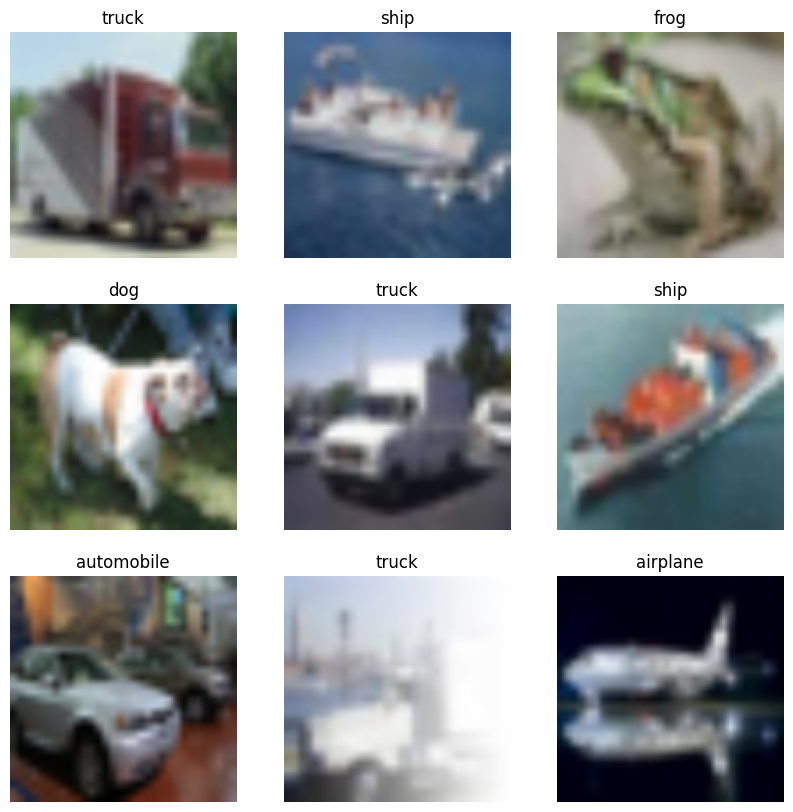

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow((images[i].numpy() * 255).astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [13]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(4* val_batches // 5)
validation_dataset = validation_dataset.skip(4* val_batches // 5)

In [14]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of train batches: 625
Number of validation batches: 32
Number of test batches: 125


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)



##   2. Load the pretrained model



In [16]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [57]:
base_model_resnet = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [17]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [58]:
preprocess_input_resnet = tf.keras.applications.resnet50.preprocess_input

In [18]:
base_model.trainable = False

In [59]:
base_model_resnet.trainable = False

In [19]:
base_model.summary()

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [60]:
base_model_resnet.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [20]:
# pip list | findstr tensorflow

In [21]:
# pip show numpy

In [22]:
image_batch, label_batch = next(iter(train_dataset))
print("Batch shapes:", image_batch.shape, label_batch.shape)


Batch shapes: (64, 128, 128, 3) (64,)


2025-07-04 19:28:45.027967: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [23]:
print("Dtype:", image_batch.dtype)
print("Min value:", tf.reduce_min(image_batch).numpy())
print("Max value:", tf.reduce_max(image_batch).numpy())

Dtype: <dtype: 'float32'>
Min value: 0.0
Max value: 1.0


In [24]:
# image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

I0000 00:00:1751639325.110448     919 cuda_dnn.cc:529] Loaded cuDNN version 90300


(64, 4, 4, 1280)


In [63]:
feature_batch_resnet = base_model_resnet(image_batch)
print(feature_batch_resnet.shape)

(64, 4, 4, 2048)




##   3. Add custom classifier head



In [25]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [64]:
global_average_layer_resnet = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_average_resnet = global_average_layer(feature_batch_resnet)
print(feature_batch_average_resnet.shape)

(64, 2048)


In [26]:
prediction_layer = tf.keras.layers.Dense(10, activation='softmax')

prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 10)


In [65]:
prediction_layer_resnet = tf.keras.layers.Dense(10, activation='softmax')

prediction_batch_resnet = prediction_layer_resnet(feature_batch_average_resnet)
print(prediction_batch_resnet.shape)

(64, 10)


In [27]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
])

In [28]:
dropout_layer = tf.keras.layers.Dropout(0.2)

In [29]:
inputs = tf.keras.Input(shape=(IMG_SIZE[0],IMG_SIZE[1], 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = dropout_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [66]:
inputs = tf.keras.Input(shape=(IMG_SIZE[0],IMG_SIZE[1], 3))
x = data_augmentation(inputs)
x = preprocess_input_resnet(x)
x = base_model_resnet(x, training=False)
x = global_average_layer_resnet(x)
x = dropout_layer(x)
outputs = prediction_layer_resnet(x)
model_resnet = tf.keras.Model(inputs, outputs)

In [30]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [67]:
model_resnet.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │          0 │ input_layer_5[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 128, 128)  │          0 │ sequential[2][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 128, 128)  │          0 │ sequential[2][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 128, 128)  │          0 │ sequential[2][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 128, 128,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 128,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 4, 4,      │ 23,587,712 │ add_1[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[1][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10)        │     20,490 │ dropout[2][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [31]:
len(model.trainable_variables)

2

## 4.Train the model

In [32]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

In [68]:
base_learning_rate = 0.0001
model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

Check model accuracy and los when model is untrained

In [33]:
loss0, accuracy0 = model.evaluate(validation_dataset)

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.1049 - loss: 2.5558


In [69]:
loss0, accuracy0 = model_resnet.evaluate(validation_dataset)

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.0993 - loss: 2.7049


In [70]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.5,
                                                 patience=3,
                                                 min_lr=1e-6,
                                                 verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_tuned_model.keras',
                                                monitor='val_loss',
                                                save_best_only=True,
                                                verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=10,
                                              restore_best_weights=True,
                                              verbose=1)

In [35]:
initial_epochs = 100


history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[reduce_lr, checkpoint, early_stop])

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.0990 - loss: 2.4484
Epoch 1: val_loss improved from inf to 2.30466, saving model to best_tuned_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 64s 96ms/step - accuracy: 0.0990 - loss: 2.4483 - val_accuracy: 0.1015 - val_loss: 2.3047 - learning_rate: 1.0000e-04
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.1015 - loss: 2.3991
Epoch 2: val_loss improved from 2.30466 to 2.29177, saving model to best_tuned_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 96ms/step - accuracy: 0.1015 - loss: 2.3991 - val_accuracy: 0.1070 - val_loss: 2.2918 - learning_rate: 1.0000e-04
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.1019 - loss: 2.3742
Epoch 3: val_loss improved from 2.29177 to 2.28507, saving model to best_tuned_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 96ms/step - accuracy: 0.1019 - loss: 2.3742 - val_accuracy: 0.1170 - val_loss: 2.2851 - learning_rate: 1.0000e-04
Epoch 4/100
625/625 ━━━━━━

In [71]:
initial_epochs = 100


history_resnet = model_resnet.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[reduce_lr, checkpoint, early_stop])

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.1038 - loss: 2.4623
Epoch 1: val_loss improved from inf to 2.29793, saving model to best_tuned_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 121ms/step - accuracy: 0.1038 - loss: 2.4622 - val_accuracy: 0.1100 - val_loss: 2.2979 - learning_rate: 1.0000e-04
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.1063 - loss: 2.3266
Epoch 2: val_loss improved from 2.29793 to 2.29142, saving model to best_tuned_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 121ms/step - accuracy: 0.1063 - loss: 2.3266 - val_accuracy: 0.1340 - val_loss: 2.2914 - learning_rate: 1.0000e-04
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.1155 - loss: 2.3080
Epoch 3: val_loss improved from 2.29142 to 2.28516, saving model to best_tuned_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 120ms/step - accuracy: 0.1155 - loss: 2.3080 - val_accuracy: 0.1650 - val_loss: 2.2852 - learning_rate: 1.0000e-04
Epoch 4/100
625/625 

In [36]:
loss1, accuracy1 = model.evaluate(test_dataset)
print('Test loss :', loss1)
print('Test accuracy :', accuracy1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.2992 - loss: 2.0559
Test loss : 2.0586729049682617
Test accuracy : 0.2985000014305115


In [72]:
loss1_res, accuracy1_res = model_resnet.evaluate(test_dataset)
print('Test loss :', loss1_res)
print('Test accuracy :', accuracy1_res)

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 95ms/step - accuracy: 0.2743 - loss: 2.1043
Test loss : 2.1070783138275146
Test accuracy : 0.27399998903274536


In [37]:
history_df = pd.DataFrame(history.history)

In [73]:
history_df_resnet = pd.DataFrame(history_resnet.history)

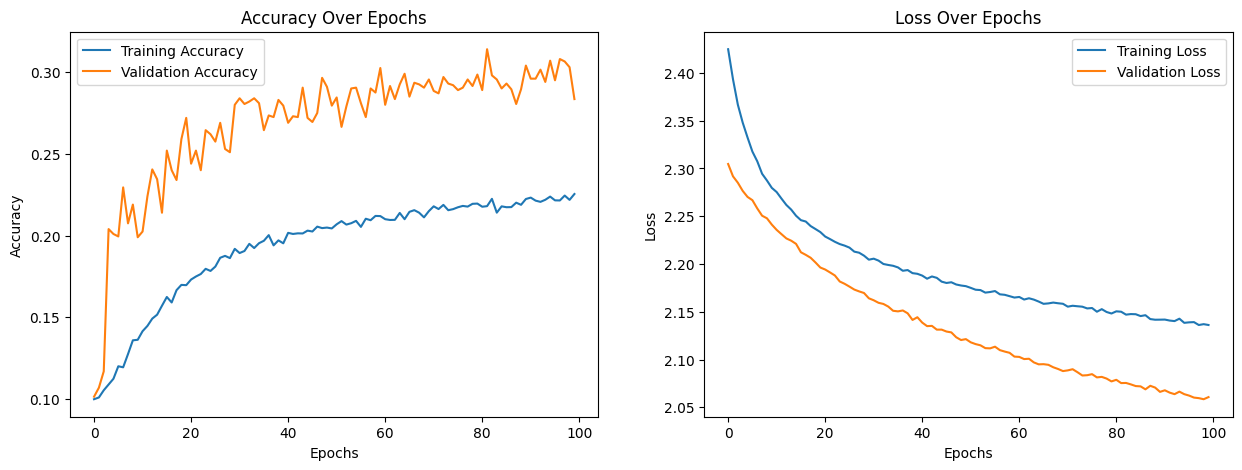

In [74]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

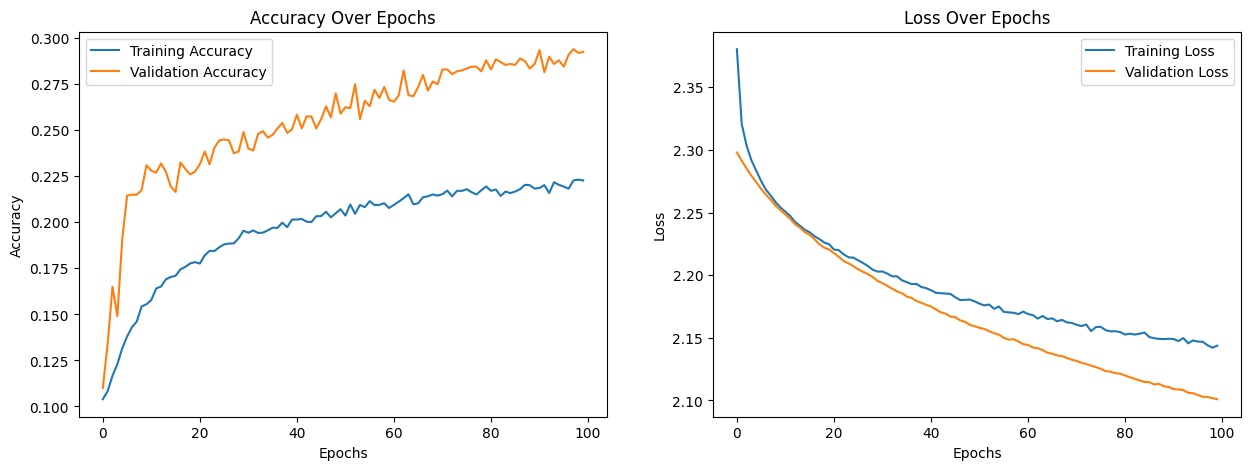

In [75]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df_resnet['accuracy'], label='Training Accuracy')
plt.plot(history_df_resnet['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df_resnet['loss'], label='Training Loss')
plt.plot(history_df_resnet['val_loss'], label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [39]:
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []
for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

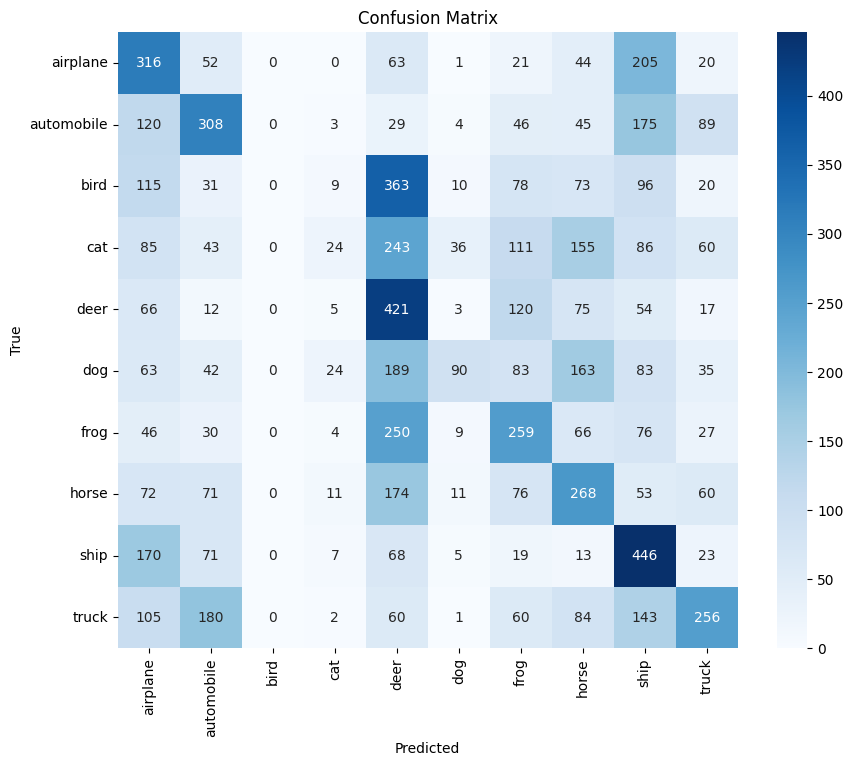

In [40]:
# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 5. Fine-tune top few layers of the base model after initial training

In [41]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [42]:
base_model.trainable = True

In [76]:
base_model_resnet.trainable = True

In [43]:
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [77]:
fine_tune_at = 100

for layer in base_model_resnet.layers[:fine_tune_at]:
  layer.trainable = False

In [44]:
len(model.trainable_variables)

56

In [78]:
len(model_resnet.trainable_variables)

92

In [45]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=["accuracy"])

In [79]:
model_resnet.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=["accuracy"])

In [46]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 1,874,250 (7.15 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [80]:
model_resnet.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │          0 │ input_layer_5[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 128, 128)  │          0 │ sequential[2][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 128, 128)  │          0 │ sequential[2][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 128, 128)  │          0 │ sequential[2][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 128, 128,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 128,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 4, 4,      │ 23,587,712 │ add_1[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[1][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10)        │     20,490 │ dropout[2][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 19,473,418 (74.29 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

In [47]:
fine_tune_epochs = 200
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset,
                         callbacks=[reduce_lr, checkpoint, early_stop])

Epoch 101/300
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.1967 - loss: 4.8832
Epoch 101: val_loss did not improve from 2.05849
625/625 ━━━━━━━━━━━━━━━━━━━━ 221s 337ms/step - accuracy: 0.1968 - loss: 4.8808 - val_accuracy: 0.0930 - val_loss: 11.2804 - learning_rate: 1.0000e-05
Epoch 102/300
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.2708 - loss: 2.1930
Epoch 102: val_loss did not improve from 2.05849
625/625 ━━━━━━━━━━━━━━━━━━━━ 209s 335ms/step - accuracy: 0.2708 - loss: 2.1928 - val_accuracy: 0.1010 - val_loss: 16.8208 - learning_rate: 1.0000e-05
Epoch 103/300
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.3209 - loss: 1.9178
Epoch 103: val_loss did not improve from 2.05849
625/625 ━━━━━━━━━━━━━━━━━━━━ 207s 332ms/step - accuracy: 0.3210 - loss: 1.9177 - val_accuracy: 0.1010 - val_loss: 17.2895 - learning_rate: 1.0000e-05
Epoch 104/300
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.3516 - loss: 1.8221
Epoch 104: ReduceLROnPlateau reducing l

In [ ]:
fine_tune_epochs = 200
total_epochs =  initial_epochs + fine_tune_epochs

history_fine_resnet = model_resnet.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset,
                         callbacks=[reduce_lr, checkpoint, early_stop])

Epoch 101/300
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.2265 - loss: 3.4903
Epoch 101: val_loss improved from 2.10096 to 1.88626, saving model to best_tuned_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 316s 481ms/step - accuracy: 0.2265 - loss: 3.4885 - val_accuracy: 0.3450 - val_loss: 1.8863 - learning_rate: 1.0000e-05
Epoch 102/300
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.3492 - loss: 1.8183
Epoch 102: val_loss improved from 1.88626 to 1.77818, saving model to best_tuned_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 301s 482ms/step - accuracy: 0.3492 - loss: 1.8182 - val_accuracy: 0.3815 - val_loss: 1.7782 - learning_rate: 1.0000e-05
Epoch 103/300
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.3878 - loss: 1.7187
Epoch 103: val_loss improved from 1.77818 to 1.58875, saving model to best_tuned_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 293s 469ms/step - accuracy: 0.3878 - loss: 1.7187 - val_accuracy: 0.4255 - val_loss: 1.5888 - learning_rate: 1.0000e-05
E

In [48]:
loss2, accuracy2 = model.evaluate(test_dataset)
print('Test loss :', loss2)
print('Test accuracy :', accuracy2)

125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.5195 - loss: 1.3636
Test loss : 1.3733702898025513
Test accuracy : 0.5133749842643738


In [ ]:
loss2_resnet, accuracy2_resnet = model_resnet.evaluate(test_dataset)
print('Test loss :', loss2_resnet)
print('Test accuracy :', accuracy2_resnet)

In [49]:
history_fine_df = pd.DataFrame(history_fine.history)
history_fine_df.index += len(history_df)

In [ ]:
history_fine_df_resnet = pd.DataFrame(history_fine_resnet.history)
history_fine_df_resnet.index += len(history_df_resnet)

In [50]:
history_full_df = pd.concat([history_df, history_fine_df])

In [ ]:
history_full_df_resnet = pd.concat([history_df_resnet, history_fine_df_resnet])

In [51]:
finetune_start_epoch = len(history_df)

In [ ]:
finetune_start_epoch_resnet = len(history_df_resnet)

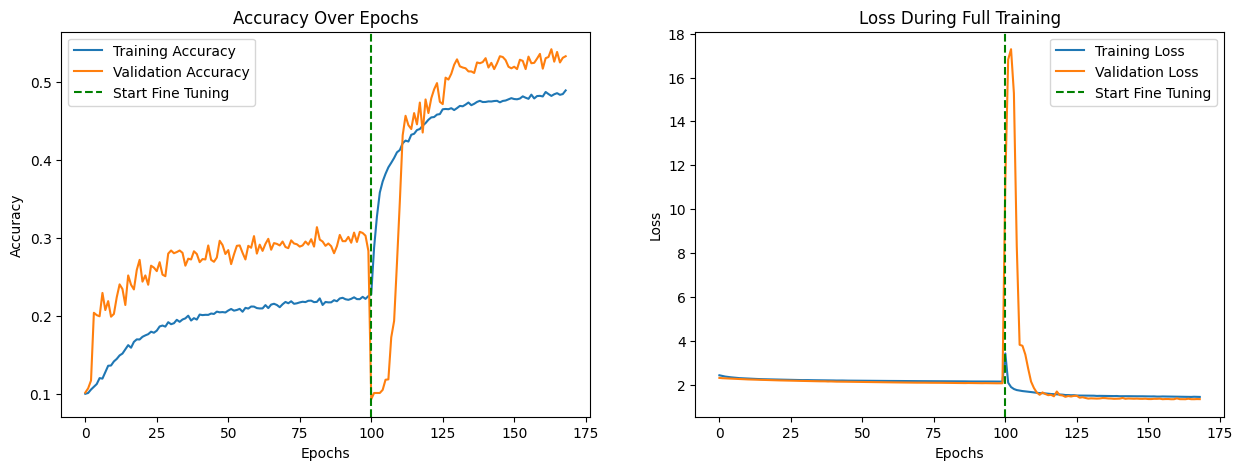

In [52]:
plt.figure(figsize=(15, 5))

# --- Accuracy Plot ---
plt.subplot(1, 2, 1)
plt.plot(history_full_df['accuracy'], label='Training Accuracy')
plt.plot(history_full_df['val_accuracy'], label='Validation Accuracy')
plt.axvline(x=finetune_start_epoch, linestyle='--', color='green', label='Start Fine Tuning')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# --- Loss Plot ---
plt.subplot(1, 2, 2)
plt.plot(history_full_df['loss'], label='Training Loss')
plt.plot(history_full_df['val_loss'], label='Validation Loss')
plt.axvline(x=finetune_start_epoch, linestyle='--', color='green', label='Start Fine Tuning')
plt.title("Loss During Full Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [ ]:
plt.figure(figsize=(15, 5))

# --- Accuracy Plot ---
plt.subplot(1, 2, 1)
plt.plot(history_full_df_resnet['accuracy'], label='Training Accuracy')
plt.plot(history_full_df_resnet['val_accuracy'], label='Validation Accuracy')
plt.axvline(x=finetune_start_epoch_resnet, linestyle='--', color='green', label='Start Fine Tuning')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# --- Loss Plot ---
plt.subplot(1, 2, 2)
plt.plot(history_full_df_resnet['loss'], label='Training Loss')
plt.plot(history_full_df_resnet['val_loss'], label='Validation Loss')
plt.axvline(x=finetune_start_epoch_resnet, linestyle='--', color='green', label='Start Fine Tuning')
plt.title("Loss During Full Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [53]:
y_true = []
y_pred = []
for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

2025-07-05 01:24:09.757810: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


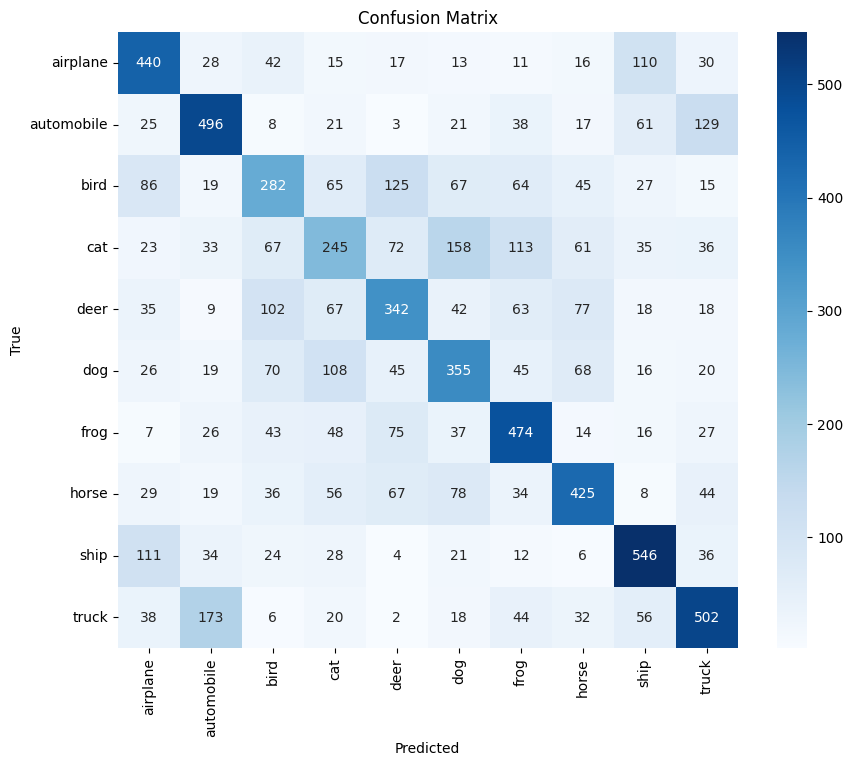

In [54]:
# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [55]:
# Print comparison side by side
print("\nComparison:")
print(f"{'Metric':<15}{'Base Model':<15}{'Fine Tuning'}")
print(f"{'-'*40}")
print(f"{'Loss':<15}{loss1:<15.4f}{loss2:.4f}")
print(f"{'Accuracy':<15}{accuracy1:<15.4f}{accuracy2:.4f}")


Comparison:
Metric         Base Model     Fine Tuning
----------------------------------------
Loss           2.0587         1.3734
Accuracy       0.2985         0.5134


In [ ]:
# Print comparison side by side
print("\nComparison: Resnet ")
print(f"{'Metric':<15}{'Base Model':<15}{'Fine Tuning'}")
print(f"{'-'*40}")
print(f"{'Loss':<15}{loss1_resnet:<15.4f}{loss2_resnet:.4f}")
print(f"{'Accuracy':<15}{accuracy1_resnet:<15.4f}{accuracy2_resnet:.4f}")

Predictions:
 [2 0 4 7 6 6 3 5 2 8 7 0 1 7 0 1 0 4 6 6 6 6 2 6 9 0 8 4 1 6 2 7 1 5 1 4 5
 1 2 3 7 3 5 0 0 7 2 1 6 7 8 2 5 8 8 1 7 3 6 2 4 8 5 3]
Labels:
 [4 0 4 7 6 6 6 0 2 8 4 0 8 7 9 5 5 0 1 6 5 6 6 6 2 8 8 3 1 3 2 7 5 5 1 4 5
 1 2 2 3 1 3 0 0 7 5 1 2 5 8 2 5 8 1 3 7 3 6 4 6 9 2 4]


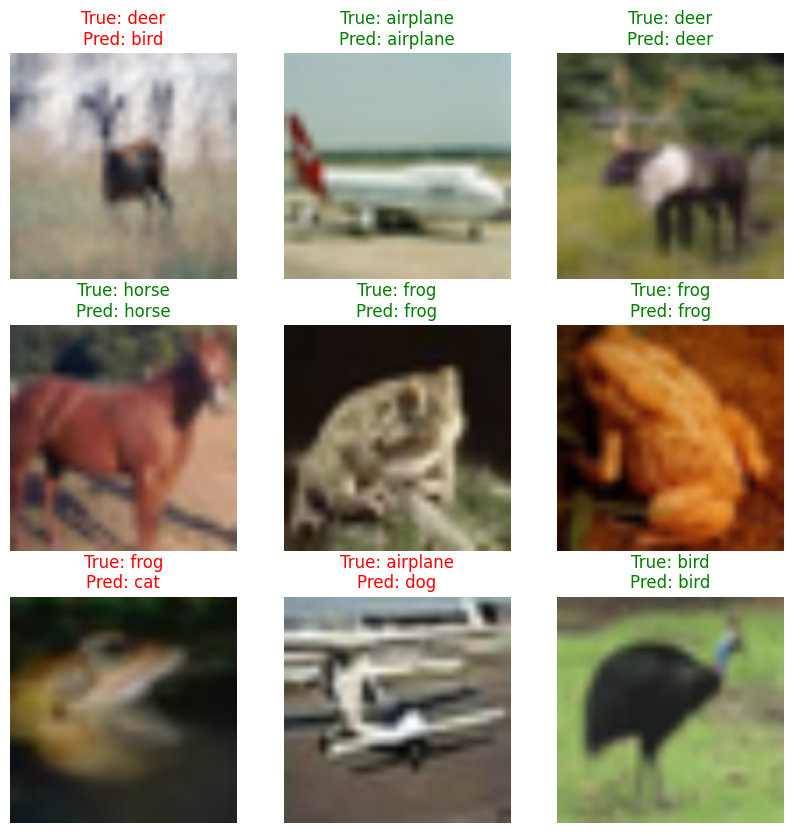

In [56]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predicted_classes = np.argmax(predictions, axis=1)

print('Predictions:\n', predicted_classes)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow((image_batch[i] * 255).astype("uint8"))
  true_label = class_names[label_batch[i]]
  predicted_label = class_names[predicted_classes[i]]
  plt.title(f"True: {true_label}\nPred: {predicted_label}", color="green" if true_label == predicted_label else "red")
  plt.axis("off")
